In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from data.dataset import EEGDatasetWrapper

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import wandb
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class EEGGraphFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_dataset, window_size=100):
        self.eeg_dataset = eeg_dataset
        self.window_size = window_size

    def __len__(self):
        return len(self.eeg_dataset)

    def __getitem__(self, idx):
        signal, label = self.eeg_dataset[idx]  # signal shape: (seq_len, num_electrodes)
        features = self.extract_graph_features(signal)  # (num_windows, num_electrodes, fft_dim)
        return features, label

    def extract_graph_features(self, signal):
        """
        Args:
            signal: numpy array of shape (seq_len, num_electrodes)
        Returns:
            Tensor of shape (num_windows, num_freqs, num_electrodes)
        """
        seq_len, num_electrodes = signal.shape
        fs = 250  # Hz
        step = int(self.window_size)
        windows = []

        for start in range(0, seq_len - self.window_size + 1, step):
            windows.append(signal[start:start+self.window_size])

        windows = np.stack(windows)  # (num_windows, window_size, num_electrodes)
        
        # FFT along time axis
        fft_windows = np.fft.fft(windows, axis=1)
        fft_windows = np.abs(fft_windows)
        fft_windows = np.log(np.maximum(fft_windows, 1e-8))  # Log power

        # Frequency selection
        freqs = np.fft.fftfreq(self.window_size, d=1/fs)
        pos_mask = (freqs >= 0.5) & (freqs <= 30)
        fft_windows = fft_windows[:, pos_mask, :]  # (num_windows, num_freqs, num_electrodes)

        return torch.from_numpy(fft_windows).float()

In [3]:
data_root = "data/data"
data_preprocessing = "raw"
eeg_data_wrapper= EEGDatasetWrapper(
    data_root,
    data_preprocessing)

In [4]:
selected_ids = eeg_data_wrapper.get_subject_ids()
validation_id = "s002" 
selected_ids.remove(validation_id)
train_dataset, val_dataset = eeg_data_wrapper.leave_one_out_split(
        validation_id, selected_ids
)

labels = train_dataset.get_label_array()
labels = np.array(labels)
# get ratio positive and negative samples
pos_ratio = np.sum(labels == 0) / np.sum(labels == 1)
print(f"Positive ratio: {pos_ratio:.2f}")

train_data_label_1 = []
train_data_label_0 = []
for i, (train_data, label) in enumerate(train_dataset):
        if label == 1:
                train_data_label_1.append((train_data, label))
        else:
                train_data_label_0.append((train_data, label))
train_data_label_1 = np.array(train_data_label_1, dtype=object)
train_data_label_0 = np.array(train_data_label_0, dtype=object)
print(f"Number of samples with label 1: {len(train_data_label_1)}")
print(f"Number of samples with label 0: {len(train_data_label_0)}")
# Resample the data to have the same number of samples
num_samples = min(len(train_data_label_1), len(train_data_label_0))
#randomly select samples from the larger class
train_data_label_0 = train_data_label_0[np.random.choice(len(train_data_label_0), num_samples, replace=False)]
train_data_label_1 = train_data_label_1[np.random.choice(len(train_data_label_1), num_samples, replace=False)]
train_dataset = np.concatenate((train_data_label_0, train_data_label_1), axis=0)
# Shuffle the dataset
np.random.shuffle(train_dataset)
# Convert to DataLoader

print(f"Number of samples in the training set: {len(train_dataset)}")
train_dataset = EEGGraphFeatureDataset(train_dataset, window_size=500)
val_dataset = EEGGraphFeatureDataset(val_dataset, window_size=500)
test_data , label = train_dataset.__getitem__(0)

print(f"Test data shape: {test_data.shape}")
print (test_data)

Positive ratio: 4.00
Number of samples with label 1: 2096
Number of samples with label 0: 8393
Number of samples in the training set: 4192
Test data shape: torch.Size([6, 60, 19])
tensor([[[-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         ...,
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207]],

        [[-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         ...,
         [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
         [-18.4207, 

In [5]:
train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
val_loader = DataLoader(val_dataset, batch_size=32,shuffle = True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import dense_to_sparse


class R_GAT_Model(nn.Module):
    def __init__(self, input_dim, gat_hidden_dim=64, output_dim=1, gat_heads=1, embed_dim=64, nhead=1, num_layers=1):
        super(R_GAT_Model, self).__init__()
        self.num_electrodes = 19
        self.gat_heads = gat_heads
        self.input_dim = input_dim  # num_freqs (feature per node)

        # Debug containers
        self.debug_info = {}

        # GAT 1 (per-window spatial)
        self.gat1 = GATv2Conv(in_channels=input_dim, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)

        # Transformer (temporal)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=gat_hidden_dim * gat_heads,
            nhead=nhead,
            dim_feedforward=gat_hidden_dim * gat_heads * 4,
            dropout=0.2,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm1 = nn.LayerNorm(gat_hidden_dim * gat_heads)

        # GAT 2 (global spatial)
        self.gat2 = GATv2Conv(in_channels=gat_hidden_dim * gat_heads, out_channels=gat_hidden_dim, heads=1, concat=True)

        # Attention pooling
        self.attention_pool = nn.Linear(gat_hidden_dim, 1)

        # Final classifier
        self.fc = nn.Linear(gat_hidden_dim, output_dim)

    def build_fully_connected_graph(self, num_nodes):
        adj = torch.ones(num_nodes, num_nodes)  # fully connected
        edge_index, _ = dense_to_sparse(adj)    # includes self-loops
        return edge_index

    def forward(self, x, return_debug=False):
        """
        Args:
            x: Tensor of shape (batch_size, num_windows, num_freqs, num_electrodes)
            return_debug: If True, also returns intermediate tensors for debugging
        Returns:
            logits: (batch_size,) or (logits, debug_dict)
        """
        batch_size, num_windows, num_freqs, num_electrodes = x.shape
        edge_index = self.build_fully_connected_graph(num_electrodes).to(x.device)

        graph_outputs = []
        all_attn_scores = []
        debug_dict = {
            'gat1_out': [],
            'transformer_out': [],
            'gat2_out': [],
            'attn_scores': [],
            'graph_embeddings': []
        }

        for b in range(batch_size):
            temporal_node_embeddings = []

            for i in range(num_windows):
                window_feature = x[b, i].permute(1, 0)  # (electrodes, freqs)
                gat_out = self.gat1(window_feature, edge_index)
                temporal_node_embeddings.append(gat_out)

            node_seq = torch.stack(temporal_node_embeddings, dim=0).permute(1, 0, 2)  # (nodes, windows, dim)

            trans_out = self.transformer_encoder(node_seq)
            trans_out = self.norm1(trans_out)

            node_embeddings = trans_out.mean(dim=1)  # (nodes, dim)
            #final_gat_out = self.gat2(node_embeddings, edge_index)

            attn_scores = torch.softmax(self.attention_pool(node_embeddings), dim=0)
            pooled = (attn_scores * node_embeddings).sum(dim=0)

            # Save for debugging
            debug_dict['gat1_out'].append(temporal_node_embeddings[0].detach().cpu())
            debug_dict['transformer_out'].append(trans_out.detach().cpu())
            #debug_dict['gat2_out'].append(final_gat_out.detach().cpu())
            debug_dict['attn_scores'].append(attn_scores.detach().cpu())
            debug_dict['graph_embeddings'].append(pooled.detach().cpu())

            graph_outputs.append(pooled)

        graph_outputs = torch.stack(graph_outputs, dim=0)
        logits = self.fc(graph_outputs)

        if return_debug:
            return logits.squeeze(1), debug_dict
        return logits.squeeze(1)

    def get_graph_embeddings(self, x):
        """
        Returns: tensor (batch_size, hidden_dim)
        """
        logits, debug = self.forward(x, return_debug=True)
        return torch.stack(debug["graph_embeddings"], dim=0)


In [20]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: weight for class 1
        gamma: focusing parameter
        reduction: 'mean', 'sum' or 'none'
        """
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        logits: raw model output (before sigmoid), shape (batch,)
        labels: ground truth labels (0 or 1), shape (batch,)
        """
        probs = torch.sigmoid(logits)
        probs = probs.clamp(min=1e-7, max=1 - 1e-7)  # numerical stability
        labels = labels.float()

        p_t = probs * labels + (1 - probs) * (1 - labels)
        alpha_t = self.alpha * labels + (1 - self.alpha) * (1 - labels)

        focal_term = (1 - p_t) ** self.gamma
        loss = -alpha_t * focal_term * torch.log(p_t + 1e-9)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model = R_GAT_Model(input_dim=60).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#    optimizer, mode='min', factor=0.5, patience=3, verbose=True
#)
#loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

pos_weight = torch.tensor([pos_ratio])
loss_fn = nn.BCEWithLogitsLoss() #pos_weight=pos_weight)

wandb.init(
    project="R_GAT",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryWeightedLoss",
        "alpha": 0.75,
        "gamma": 2.0,
        "model": "R_GAT_EEG"
    }
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        #scheduler.step(avg_loss)
        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})
        

/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [9]:
model.eval()
val_loss = 0.0
predictions = []
true_labels = []

# For debugging
all_attn_scores = []
all_embeddings = []
all_gat1_out = []
all_transformer_out = []

with torch.no_grad():
    loop = tqdm(train_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits, debug = model(x_batch, return_debug=True)

        # Shapes match
        if logits.ndim != y_batch.ndim:
            y_batch = y_batch.view_as(logits)

        loss = loss_fn(logits, y_batch)
        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        # Save debug outputs
        all_attn_scores.extend(debug["attn_scores"])
        all_embeddings.extend(debug["graph_embeddings"])
        all_gat1_out.extend(debug["gat1_out"])
        all_transformer_out.extend(debug["transformer_out"])

        loop.set_postfix(batch_loss=loss.item())

avg_val_loss = val_loss / len(loop)

# Metrics
predictions = np.array(predictions)
true_labels = np.array(true_labels)
binary_preds = (predictions > 0.5).astype(int)

accuracy = accuracy_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Validation Loss: 0.5692
Accuracy: 0.6885
F1 Score: 0.7016
ROC AUC: 0.7729


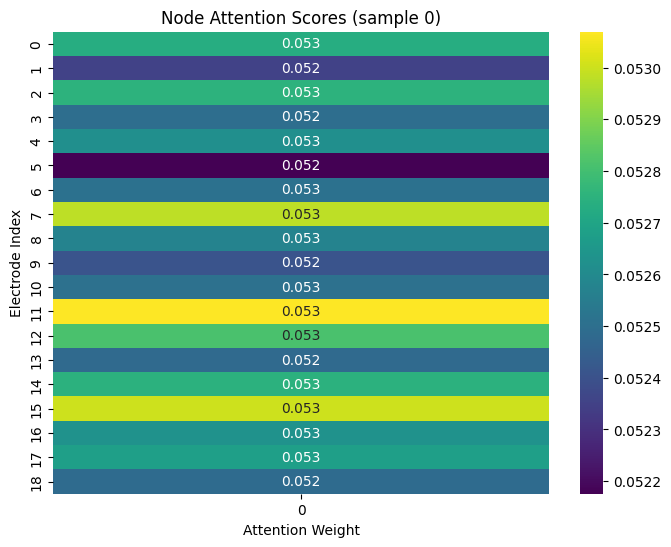

In [10]:
# Example: visualize first sample's node attention
first_attn = all_attn_scores[5].squeeze().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(first_attn.reshape(-1, 1), cmap="viridis", annot=True, cbar=True)
plt.title("Node Attention Scores (sample 0)")
plt.xlabel("Attention Weight")
plt.ylabel("Electrode Index")
plt.show()


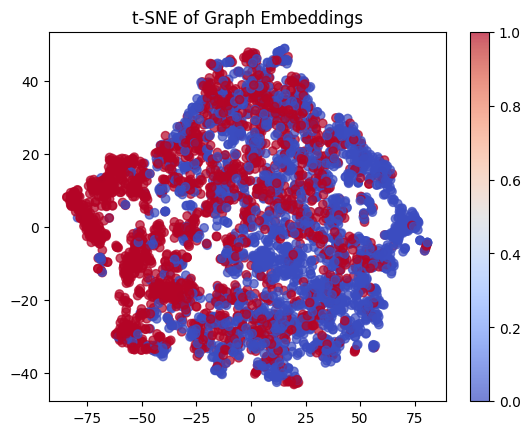

In [11]:
from sklearn.manifold import TSNE

z = TSNE(n_components=2).fit_transform(np.stack(all_embeddings))
plt.scatter(z[:, 0], z[:, 1], c=true_labels, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE of Graph Embeddings")
plt.colorbar()
plt.show()


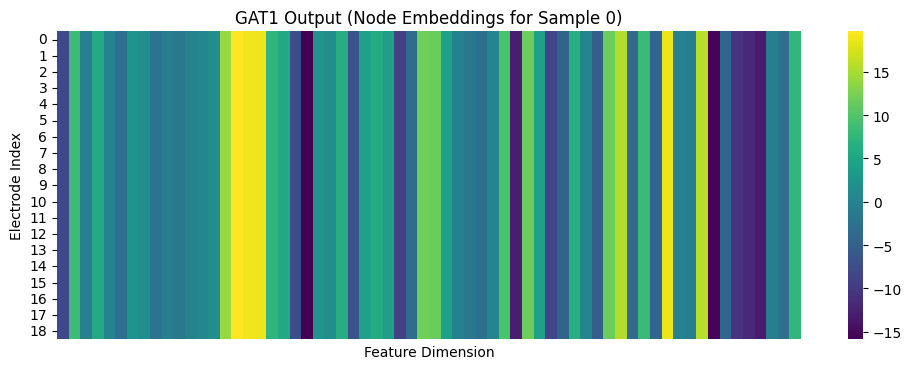

In [25]:
import seaborn as sns

node_embed = debug['gat1_out'][11].numpy()  # (num_nodes, hidden_dim)
plt.figure(figsize=(12, 4))
sns.heatmap(node_embed, cmap="viridis", xticklabels=False)
plt.title("GAT1 Output (Node Embeddings for Sample 0)")
plt.xlabel("Feature Dimension")
plt.ylabel("Electrode Index")
plt.show()


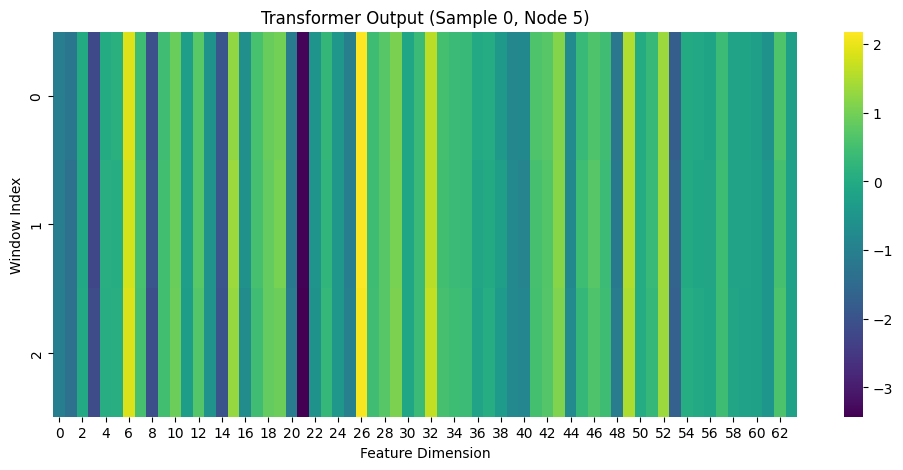

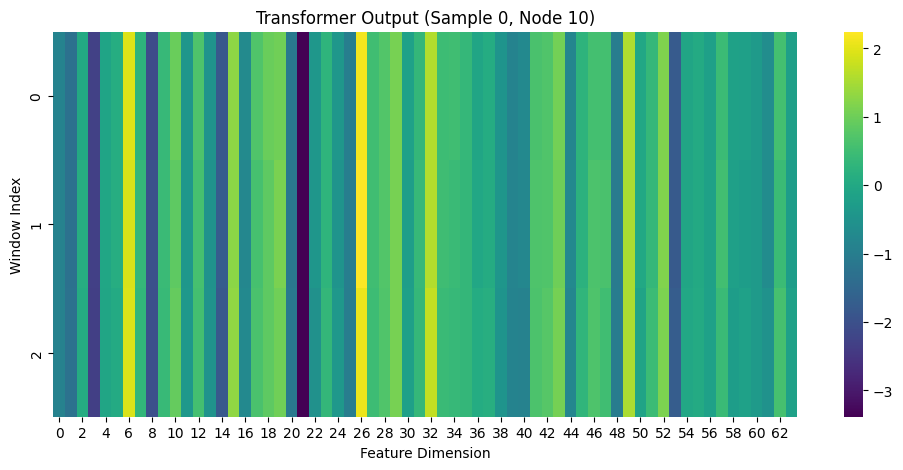

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a sample and a node (electrode)
sample_idx = 0
node_idx = 5  # pick an electrode index

transformer_out = debug['transformer_out'][sample_idx]  # (num_nodes, num_windows, hidden_dim)
node_sequence = transformer_out[node_idx].cpu().numpy()  # shape: (num_windows, hidden_dim)

plt.figure(figsize=(12, 5))
sns.heatmap(node_sequence, cmap="viridis")
plt.title(f"Transformer Output (Sample {sample_idx}, Node {node_idx})")
plt.xlabel("Feature Dimension")
plt.ylabel("Window Index")
plt.show()

# show node 6
node_idx = 10  # pick an electrode index
transformer_out = debug['transformer_out'][sample_idx + 1]  # (num_nodes, num_windows, hidden_dim)
node_sequence = transformer_out[node_idx].cpu().numpy()  # shape: (num_windows, hidden_dim)
plt.figure(figsize=(12, 5))
sns.heatmap(node_sequence, cmap="viridis")
plt.title(f"Transformer Output (Sample {sample_idx}, Node {node_idx})")
plt.xlabel("Feature Dimension")
plt.ylabel("Window Index")
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP_EEG_Classifier(nn.Module):
    def __init__(self, num_windows, num_freqs, num_electrodes, hidden_dim=256, output_dim=1):
        super(MLP_EEG_Classifier, self).__init__()
        input_dim = num_windows * num_freqs * num_electrodes

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_windows, num_freqs, num_electrodes)
        Returns:
            logits: Tensor of shape (batch_size,)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten all but batch
        logits = self.classifier(x)
        return logits.squeeze(1)  # shape: (batch,)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model_simple = MLP_EEG_Classifier(num_windows=6, num_freqs=60, num_electrodes=19).to(device)

optimizer = torch.optim.Adam(model_simple.parameters(), lr=1e-3)
#loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

loss_fn = nn.BCEWithLogitsLoss() #pos_weight=pos_weight)

wandb.init(
    project="Simple_EEG_MLP",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryEntropyLoss",
        "model": "SIMPLE_EEG_MLP"
    }
)


for epoch in range(num_epochs):
    model_simple.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model_simple(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})

wandb: Currently logged in as: cboissier77 (cboissier77-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validation Loss: 0.5560
Accuracy: 0.7859
F1 Score: 0.4786
ROC AUC: 0.7763


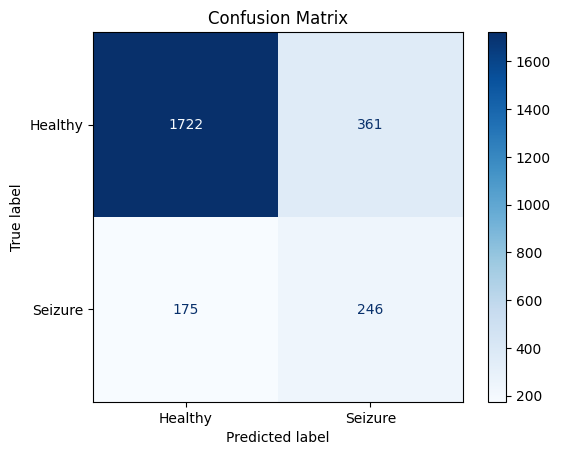

In [8]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

model_simple.eval()
val_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    loop = tqdm(val_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model_simple(x_batch)

        # Make sure shapes are compatible
        if logits.ndim != y_batch.ndim:
            y_batch = y_batch.view_as(logits)

        loss = loss_fn(logits, y_batch)
        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        loop.set_postfix(batch_loss=loss.item())

# compute average validation loss
avg_val_loss = val_loss / len(loop)

# metrics
predictions = np.array(predictions)
true_labels = np.array(true_labels)
binary_preds = (predictions > 0.5).astype(int)

accuracy = accuracy_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(true_labels, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Seizure"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
